### Hillesdon Data.

This data set is the final set of data and focuses on the value output of crops in particular areas in the Hillesdon region of the UK. The predictors would be the areas, the crops and how organic the style of farm ing would be.

The types of organic farming are:
- Cross Vompliance which is the minimum standard of organic farming that UK farmers must perform by UK agricultural law.
- ELS, the standard practise of organic farming.
- ELS-extra is the as organic as a patch of land can be farmed.


Some research papers obtained on PubMed have seen that the more organic your farming then the better your value output may become.

The EDA and cleaning of the data was very straightforward and only needed to drop a few unwanted columns (eg Unnamed 13). It was the most simple dataset to perform EDA upon.

The linear regression model gave a great training score but a horrible negative test score. This probably meant that the model was hugely overfitting and the coefficients seemed to show that there were two potential bits of data that were affecting the predicted model. Regulirization proved that the model was indeed overfitting and gave much better scores after applying lassos/ridge/elastic models to the data.

 The decision trees and random forest regressions appeared to have given a worse score.

The ELS-extra and ELS actually appeared to have a negative impact on the predicting of Value output and the less organic you are the better the predictions. Which suggests that the papers could be wrong.

In [1]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNet, ElasticNetCV
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Setting the figure sizes to make sure the graphs are set to the right sizes.

In [3]:
sns.set(rc={'figure.figsize':(40,10),
           'font.size':20})

#### Importing the data and some column dropping.

In [4]:
# Hillesdon data + dict

hill = pd.read_csv('./Hillesden_crop_yield(csv).csv')
hill_dict = pd.read_csv('./Hillesdon.csv')


In [5]:
hill = hill.drop('Ratio', axis =1)
hill = hill.drop('Notes', axis=1)
hill = hill.drop('Unnamed: 11', axis = 1)

hill = hill.drop('Unnamed: 12', axis=1)

hill = hill.drop('Unnamed: 13', axis = 1)

hill = hill.drop('Unnamed: 14', axis=1)

hill = hill.drop('Block', axis=1)


In [6]:
hill.head(2)


Year         Treatment    Field Name  Field Area          Crop  Quantity  \
0  2006  Cross-compliance      Chorleys       13.57  Oilseed rape     49.39   
1  2006  Cross-compliance  Marsh Meadow       12.18  Oilseed rape     45.55   

   Yield/ha  Defra SE regional average yield t/ha  
0      3.64                                   3.2  
1      3.74                                   3.2

In [7]:
hill.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 8 columns):
Year                                    342 non-null int64
Treatment                               342 non-null object
Field Name                              342 non-null object
Field Area                              342 non-null float64
Crop                                    342 non-null object
Quantity                                342 non-null float64
Yield/ha                                342 non-null float64
Defra SE regional average yield t/ha    342 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 21.5+ KB


In [8]:
hill.shape

(342, 8)

In [9]:
hill.isnull().sum()


Year                                    0
Treatment                               0
Field Name                              0
Field Area                              0
Crop                                    0
Quantity                                0
Yield/ha                                0
Defra SE regional average yield t/ha    0
dtype: int64

In [10]:
hill.describe(include='all')


Year  Treatment Field Name  Field Area   Crop    Quantity  \
count    342.000000        342        342   342.00000    342  342.000000   
unique          NaN          3         60         NaN      5         NaN   
top             NaN  ELS extra    Gawcott         NaN  Wheat         NaN   
freq            NaN        121          6         NaN    164         NaN   
mean    2008.500000        NaN        NaN    12.69848    NaN   82.919588   
std        1.710327        NaN        NaN     5.92143    NaN   61.418243   
min     2006.000000        NaN        NaN     2.16000    NaN    5.530000   
25%     2007.000000        NaN        NaN     8.50000    NaN   35.450000   
50%     2008.500000        NaN        NaN    12.07000    NaN   64.555500   
75%     2010.000000        NaN        NaN    15.77000    NaN  114.312500   
max     2011.000000        NaN        NaN    28.43000    NaN  290.000000   

          Yield/ha  Defra SE regional average yield t/ha  
count   342.000000                            342.000000  
unique         NaN                                   NaN  
top            NaN                                   NaN  
freq           NaN                                   NaN  
mean      6.511357                              5.683918  
std       3.390610                              2.255395  
min       0.611000                              3.000000  
25%       3.363250                              3.400000  
50%       5.900500                              5.850000  
75%       9.699250                              8.000000  
max      12.484000                              8.300000

In [11]:
hill.Crop.unique()


array(['Oilseed rape', 'Beans', 'Oilseed Rape', 'Wheat', 'Wheat_2nd'],
      dtype=object)

#### Grouping by value output (quantity) to see which regions produce the most crops.

In [12]:
cou = hill.groupby('Field Name')['Quantity'].mean()

In [13]:
cou = pd.DataFrame(cou)

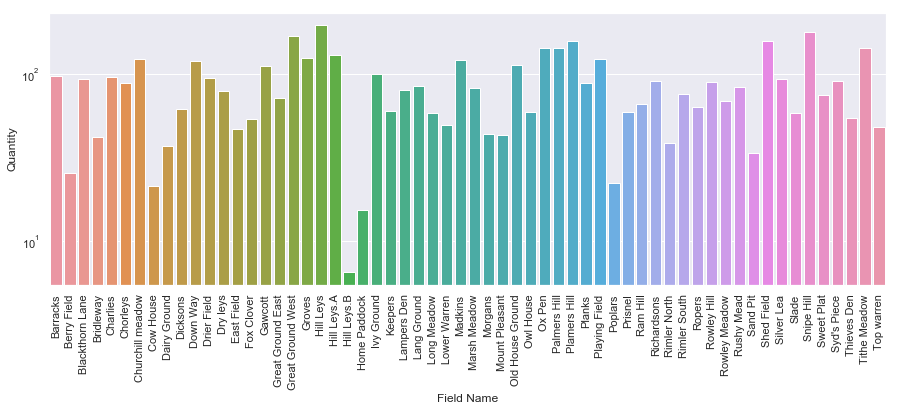

In [14]:
plt.figure(figsize=(15,5))

country_graph = sns.barplot(x=cou.index, y=cou.Quantity)
country_graph.set(yscale='log')
plt.xticks(rotation=90);

#### Dummifying the datasets.

In [15]:
cropped = pd.get_dummies(hill, drop_first=True)

In [16]:
cropped

Year  Field Area  Quantity  Yield/ha  \
0    2006       13.57    49.390     3.640   
1    2006       12.18    45.550     3.740   
2    2006       15.87    60.030     3.783   
3    2006       11.76    42.570     3.620   
4    2006       21.48    79.480     3.700   
5    2006        9.09    33.720     3.710   
6    2006        9.43    29.520     3.130   
7    2006        4.16    13.150     3.161   
8    2006        9.03    31.370     3.474   
9    2006        4.00    10.120     2.530   
10   2006       14.26    47.910     3.360   
11   2006       11.47    35.440     3.090   
12   2006       18.18    57.360     3.155   
13   2006        6.84    22.100     3.231   
14   2006       18.06    53.220     2.947   
15   2006       14.27    46.660     3.270   
16   2006       18.01    52.410     2.910   
17   2006       24.37    77.010     3.160   
18   2006        6.59    21.480     3.259   
19   2006       17.03    59.930     3.519   
20   2006        7.06    19.130     2.710   
21   2006        9.72    34.730     3.573   
22   2006        7.03    19.820     2.819   
23   2006       22.81    67.290     2.950   
24   2006       14.91    49.800     3.340   
25   2006       13.64    39.970     2.930   
26   2006        8.23    25.510     3.100   
27   2006        5.63    18.640     3.311   
28   2006       11.55    39.150     3.390   
29   2006        7.02    17.550     2.500   
..    ...         ...       ...       ...   
312  2011        5.45    54.800    10.055   
313  2011       11.28   107.800     9.557   
314  2011        5.80    28.500     4.914   
315  2011       12.54   151.000    12.041   
316  2011        2.21    27.000    12.217   
317  2011        8.50    87.000    10.235   
318  2011       11.73   142.000    12.106   
319  2011        7.93    99.000    12.484   
320  2011        9.85    15.387     1.562   
321  2011       10.96    17.063     1.557   
322  2011       12.07    19.424     1.609   
323  2011        8.12    12.492     1.538   
324  2011       14.12    76.500     5.418   
325  2011       15.59    24.375     1.564   
326  2011       15.10    23.004     1.523   
327  2011       12.22    66.750     5.462   
328  2011       18.24    92.250     5.058   
329  2011       20.95   123.000     5.871   
330  2011       14.38    75.000     5.216   
331  2011       11.76    39.000     3.316   
332  2011       25.32    70.500     2.784   
333  2011       15.77    45.000     2.854   
334  2011        3.31    11.250     3.399   
335  2011        9.73    33.000     3.392   
336  2011        6.67    34.500     5.172   
337  2011       14.65    45.750     3.123   
338  2011       22.24    85.500     3.844   
339  2011       26.85   101.250     3.771   
340  2011        8.77    33.750     3.848   
341  2011       27.60   121.500     4.402   

     Defra SE regional average yield t/ha  Treatment_ELS  Treatment_ELS extra  \
0                                     3.2              0                    0   
1                                     3.2              0                    0   
2                                     3.2              0                    0   
3                                     3.2              1                    0   
4                                     3.2              1                    0   
5                                     3.2              1                    0   
6                                     3.2              1                    0   
7                                     3.2              0                    1   
8                                     3.4              0                    1   
9                                     3.2              0                    1   
10                                    3.2              0                    1   
11                                    3.2              0                    1   
12                                    3.4              0                    0   
13                                    3.4              0                    0   

#### Setting up the model

In [17]:
model = LinearRegression()

hill_X = cropped
hill_y = cropped.pop('Quantity')



In [18]:
hill_X.drop('Field Area', inplace=True, axis =1)

In [19]:
hill_X.drop('Defra SE regional average yield t/ha', inplace=True, axis =1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(hill_X, hill_y, test_size = 0.33)


In [21]:
scaler = StandardScaler()

In [22]:
Xs = scaler.fit_transform(X_test)


In [23]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=hill_X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=hill_X.columns)

In [24]:
def get_model_scores(model, X_train, y_train, X_test, y_test):
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print("Cross-validated training scores:", scores)
    print("Mean cross-validated training score:", scores.mean())
    model.fit(X_train, y_train)
    print("Training Score:", model.score(X_train, y_train))
    print("Test Score:", model.score(X_test, y_test))
    return model

In [25]:
sns.set(rc={'figure.figsize':(20,25),
           'font.size':20})

#### Running the linear regression and getting the coefficients.

In [26]:
model = LinearRegression()

scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
model.fit(X_train, y_train)
print("Training Score:", model.score(X_train, y_train))
print("Test Score:", model.score(X_test, y_test))  

Cross-validated training scores: [-2.15668874e+23 -3.70876760e+25 -7.82530087e+27 -2.10916561e+24
  8.46557015e-01]
Mean cross-validated training score: -1.572942676240039e+27
Training Score: 0.9021902811112422
Test Score: 0.7964017538057736


#### The test scores are in the negative here... This means there might be overfitting so let's regularize it to see.

In [27]:
df_coef = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef

coefficients      coef_abs
Year                         -1.449702e+00  1.449702e+00
Yield/ha                      3.418232e+01  3.418232e+01
Treatment_ELS                -9.228996e+14  9.228996e+14
Treatment_ELS extra           1.142948e+15  1.142948e+15
Field Name_Berry Field       -4.900862e+14  4.900862e+14
Field Name_Blackthorn Lane    8.780228e-02  8.780228e-02
Field Name_Bridleway         -5.646494e+14  5.646494e+14
Field Name_Charlies           1.278116e+00  1.278116e+00
Field Name_Chorleys          -2.785135e+14  2.785135e+14
Field Name_Churchill meadow  -4.900862e+14  4.900862e+14
Field Name_Cow House         -8.953125e+00  8.953125e+00
Field Name_Dairy Ground      -2.496655e+14  2.496655e+14
Field Name_Dicksons          -3.875000e+00  3.875000e+00
Field Name_Down Way           3.085938e+00  3.085938e+00
Field Name_Drier Field       -5.646494e+14  5.646494e+14
Field Name_Dry leys          -2.703125e+00  2.703125e+00
Field Name_East Field        -4.808594e+00  4.808594e+00
Field Name_Fox Clover        -4.093750e+00  4.093750e+00
Field Name_Gawcott           -5.646494e+14  5.646494e+14
Field Name_Great Ground East -2.166966e+14  2.166966e+14
Field Name_Great Ground West -2.496655e+14  2.496655e+14
Field Name_Groves            -2.166966e+14  2.166966e+14
Field Name_Hill Leys         -4.010380e+14  4.010380e+14
Field Name_Hill Leys.A       -4.900862e+14  4.900862e+14
Field Name_Hill Leys.B       -2.842006e+14  2.842006e+14
Field Name_Home Paddock      -4.900862e+14  4.900862e+14
Field Name_Ivy Ground        -2.496655e+14  2.496655e+14
Field Name_Keepers           -5.646494e+14  5.646494e+14
Field Name_Lampers Den       -2.496655e+14  2.496655e+14
Field Name_Lang Ground       -2.785135e+14  2.785135e+14
...                                    ...           ...
Field Name_Owl House         -6.298927e+14  6.298927e+14
Field Name_Ox Pen             5.476562e+00  5.476562e+00
Field Name_Palmers Hill      -4.010380e+14  4.010380e+14
Field Name_Plamers Hill      -4.900862e+14  4.900862e+14
Field Name_Planks             3.593750e-01  3.593750e-01
Field Name_Playing Field     -2.166966e+14  2.166966e+14
Field Name_Poplars           -6.298927e+14  6.298927e+14
Field Name_Prisnel           -5.453125e+00  5.453125e+00
Field Name_Ram Hill          -2.496655e+14  2.496655e+14
Field Name_Richardsons       -4.900862e+14  4.900862e+14
Field Name_Rimler North      -3.515625e+00  3.515625e+00
Field Name_Rimler South      -2.500000e+00  2.500000e+00
Field Name_Ropers            -6.298927e+14  6.298927e+14
Field Name_Rowley Hill       -6.298927e+14  6.298927e+14
Field Name_Rowley Meadow     -5.646494e+14  5.646494e+14
Field Name_Rushy Mead        -1.320312e+00  1.320312e+00
Field Name_Sand Pit          -7.746094e+00  7.746094e+00
Field Name_Shed Field         5.046875e+00  5.046875e+00
Field Name_Silver Lea        -4.900862e+14  4.900862e+14
Field Name_Slade             -4.900862e+14  4.900862e+14
Field Name_Snipe Hill        -2.842006e+14  2.842006e+14
Field Name_Sweet Plat        -2.785135e+14  2.785135e+14
Field Name_Syd's Piece        7.031250e-01  7.031250e-01
Field Name_Thieves Den       -3.593750e+00  3.593750e+00
Field Name_Tithe Meadow       9.187500e+00  9.187500e+00
Field Name_Top warren        -2.496655e+14  2.496655e+14
Crop_Oilseed Rape             1.250000e+00  1.250000e+00
Crop_Oilseed rape            -3.125000e-01  3.125000e-01
Crop_Wheat                    7.625000e+00  7.625000e+00
Crop_Wheat_2nd                1.960938e+00  1.960938e+00

[67 rows x 2 columns]

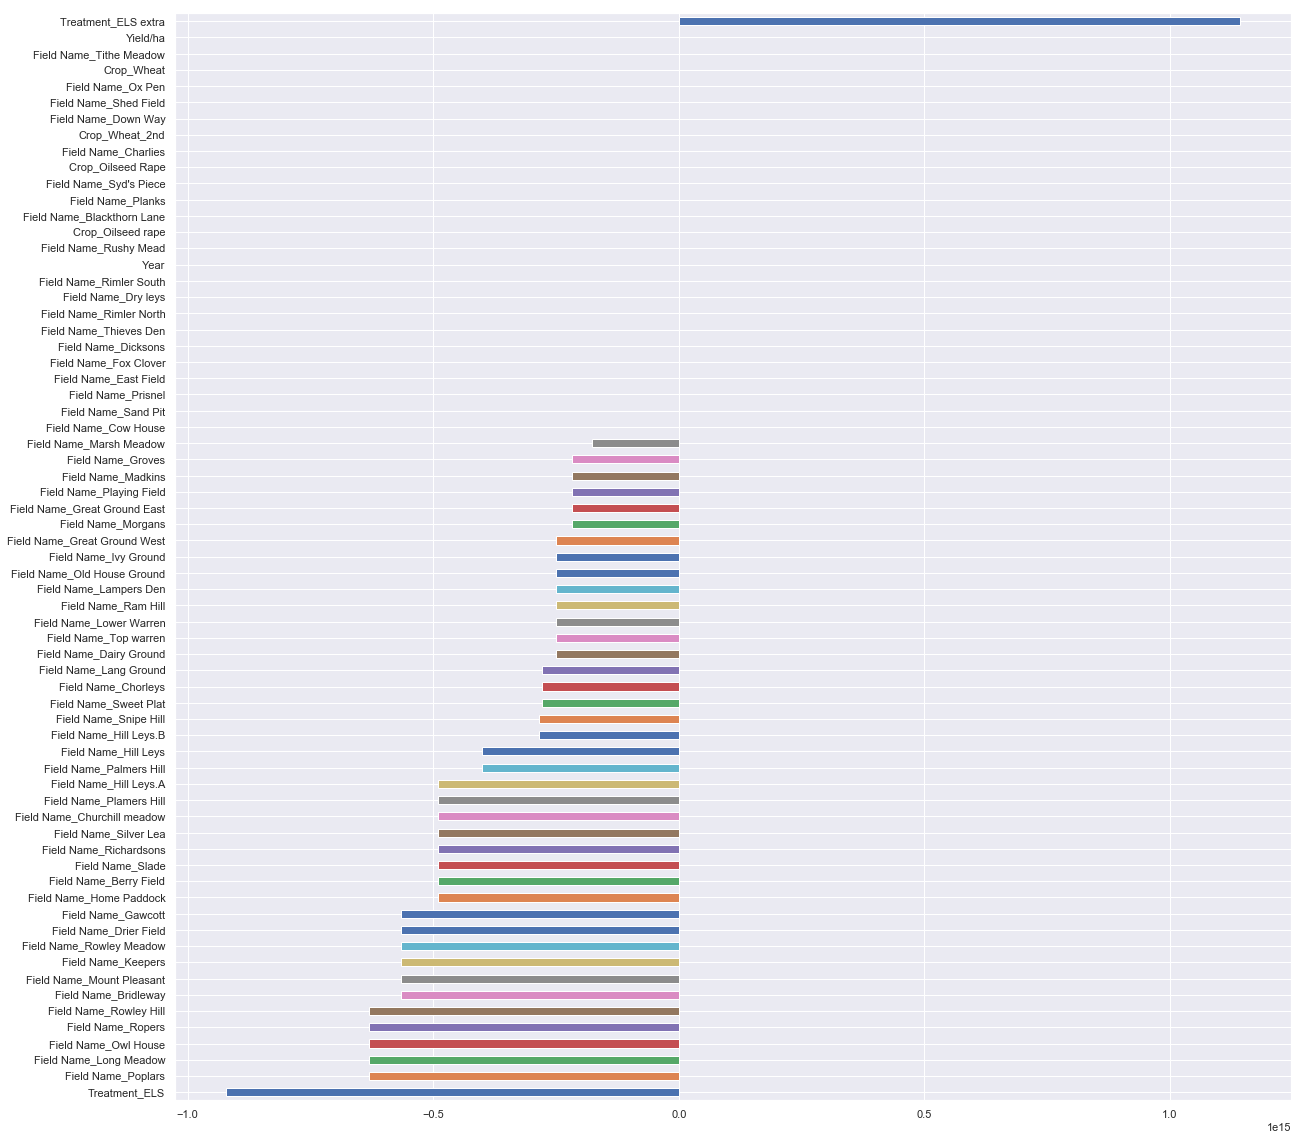

In [28]:
plt.figure(figsize=(20,20))
df_coef['coefficients'].sort_values().plot(kind='barh');

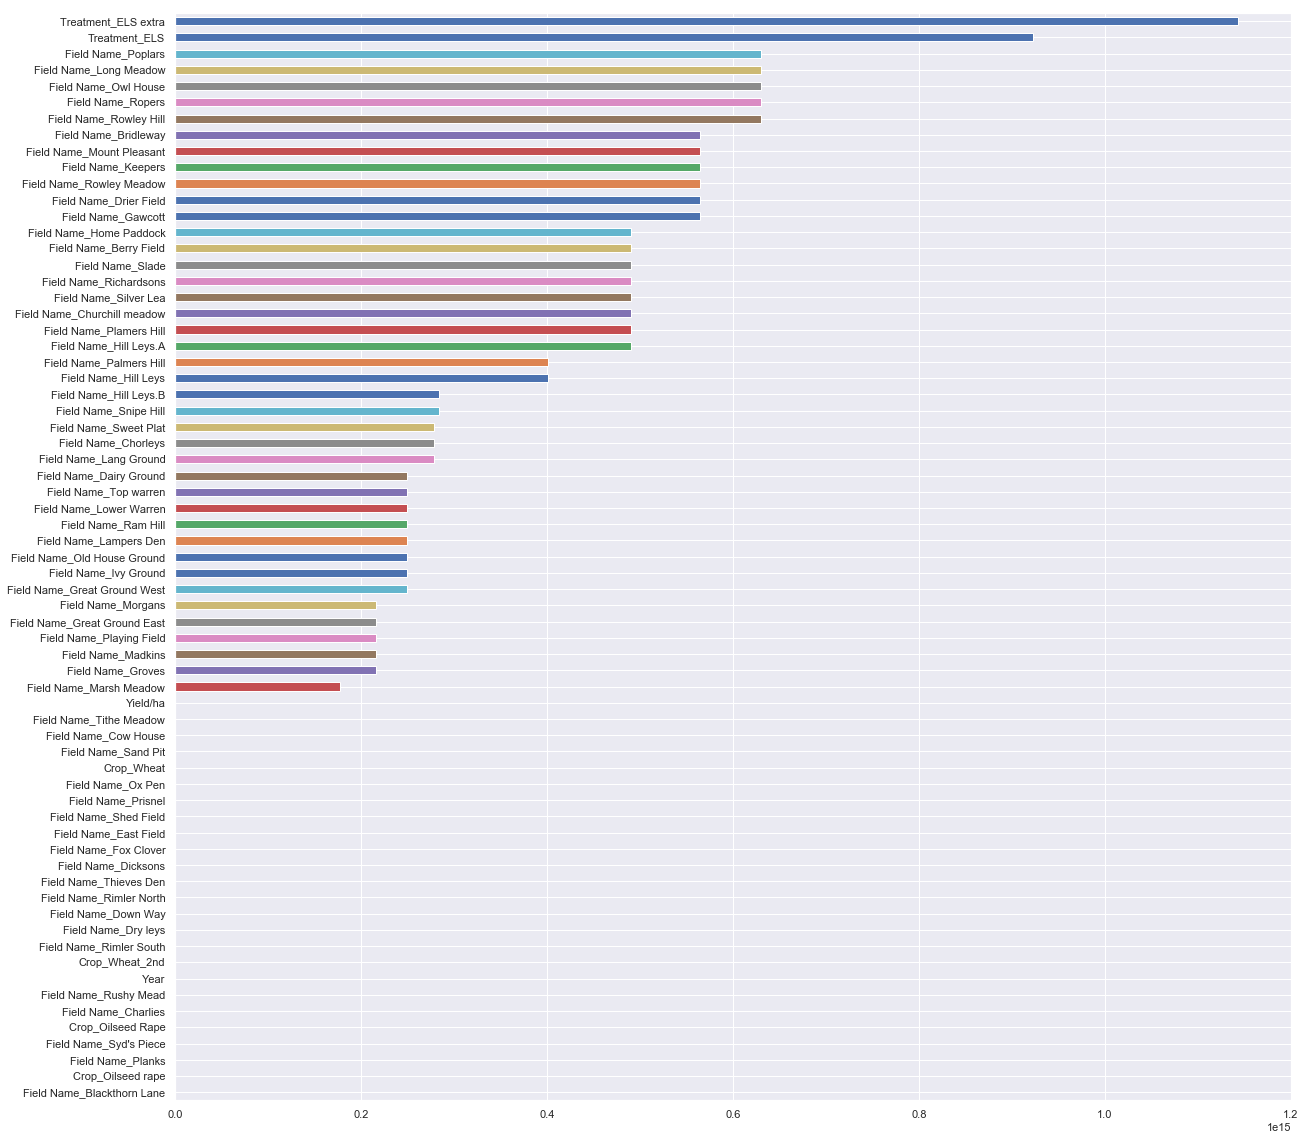

In [29]:
plt.figure(figsize=(20,20))
df_coef['coef_abs'].sort_values().plot(kind='barh');

#### Regulurization time

In [30]:
model = Ridge(alpha=21)

scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
model.fit(X_train, y_train)
print("Training Score:", model.score(X_train, y_train))
print("Test Score:", model.score(X_test, y_test))

Cross-validated training scores: [0.8810829  0.76536666 0.77098657 0.67195465 0.79181262]
Mean cross-validated training score: 0.7762406791193501
Training Score: 0.8962616603387454
Test Score: 0.7818686386878371


In [31]:
df_coef1 = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
df_coef1['coef_abs'] = df_coef1.coefficients.abs()
df_coef1

coefficients   coef_abs
Year                              0.128683   0.128683
Yield/ha                         24.989899  24.989899
Treatment_ELS                     1.395018   1.395018
Treatment_ELS extra              -2.910617   2.910617
Field Name_Berry Field           -6.773412   6.773412
Field Name_Blackthorn Lane        1.014754   1.014754
Field Name_Bridleway             -4.540389   4.540389
Field Name_Charlies               1.264076   1.264076
Field Name_Chorleys               0.194828   0.194828
Field Name_Churchill meadow       3.085164   3.085164
Field Name_Cow House             -7.706108   7.706108
Field Name_Dairy Ground          -5.395822   5.395822
Field Name_Dicksons              -2.962511   2.962511
Field Name_Down Way               3.447465   3.447465
Field Name_Drier Field            0.528765   0.528765
Field Name_Dry leys              -1.591293   1.591293
Field Name_East Field            -3.584611   3.584611
Field Name_Fox Clover            -3.395193   3.395193
Field Name_Gawcott                4.275093   4.275093
Field Name_Great Ground East     -1.334974   1.334974
Field Name_Great Ground West      9.584742   9.584742
Field Name_Groves                 5.271168   5.271168
Field Name_Hill Leys              7.411725   7.411725
Field Name_Hill Leys.A            6.956130   6.956130
Field Name_Hill Leys.B           -0.914959   0.914959
Field Name_Home Paddock         -10.237745  10.237745
Field Name_Ivy Ground             2.219126   2.219126
Field Name_Keepers               -2.124206   2.124206
Field Name_Lampers Den            0.562627   0.562627
Field Name_Lang Ground            0.384420   0.384420
...                                    ...        ...
Field Name_Owl House             -2.338059   2.338059
Field Name_Ox Pen                 5.704221   5.704221
Field Name_Palmers Hill           7.018568   7.018568
Field Name_Plamers Hill           7.110774   7.110774
Field Name_Planks                 0.573296   0.573296
Field Name_Playing Field          2.412160   2.412160
Field Name_Poplars               -7.963403   7.963403
Field Name_Prisnel               -4.384573   4.384573
Field Name_Ram Hill              -1.669968   1.669968
Field Name_Richardsons            1.050303   1.050303
Field Name_Rimler North          -2.561621   2.561621
Field Name_Rimler South          -1.821893   1.821893
Field Name_Ropers                -1.930689   1.930689
Field Name_Rowley Hill            1.937841   1.937841
Field Name_Rowley Meadow         -1.284726   1.284726
Field Name_Rushy Mead            -0.565389   0.565389
Field Name_Sand Pit              -6.588802   6.588802
Field Name_Shed Field             5.587476   5.587476
Field Name_Silver Lea             1.744553   1.744553
Field Name_Slade                 -2.944125   2.944125
Field Name_Snipe Hill             2.616646   2.616646
Field Name_Sweet Plat            -0.766338   0.766338
Field Name_Syd's Piece            0.663020   0.663020
Field Name_Thieves Den           -2.677800   2.677800
Field Name_Tithe Meadow           8.930294   8.930294
Field Name_Top warren            -3.930547   3.930547
Crop_Oilseed Rape                 0.587012   0.587012
Crop_Oilseed rape                -1.936321   1.936321
Crop_Wheat                       13.682063  13.682063
Crop_Wheat_2nd                    3.031357   3.031357

[67 rows x 2 columns]

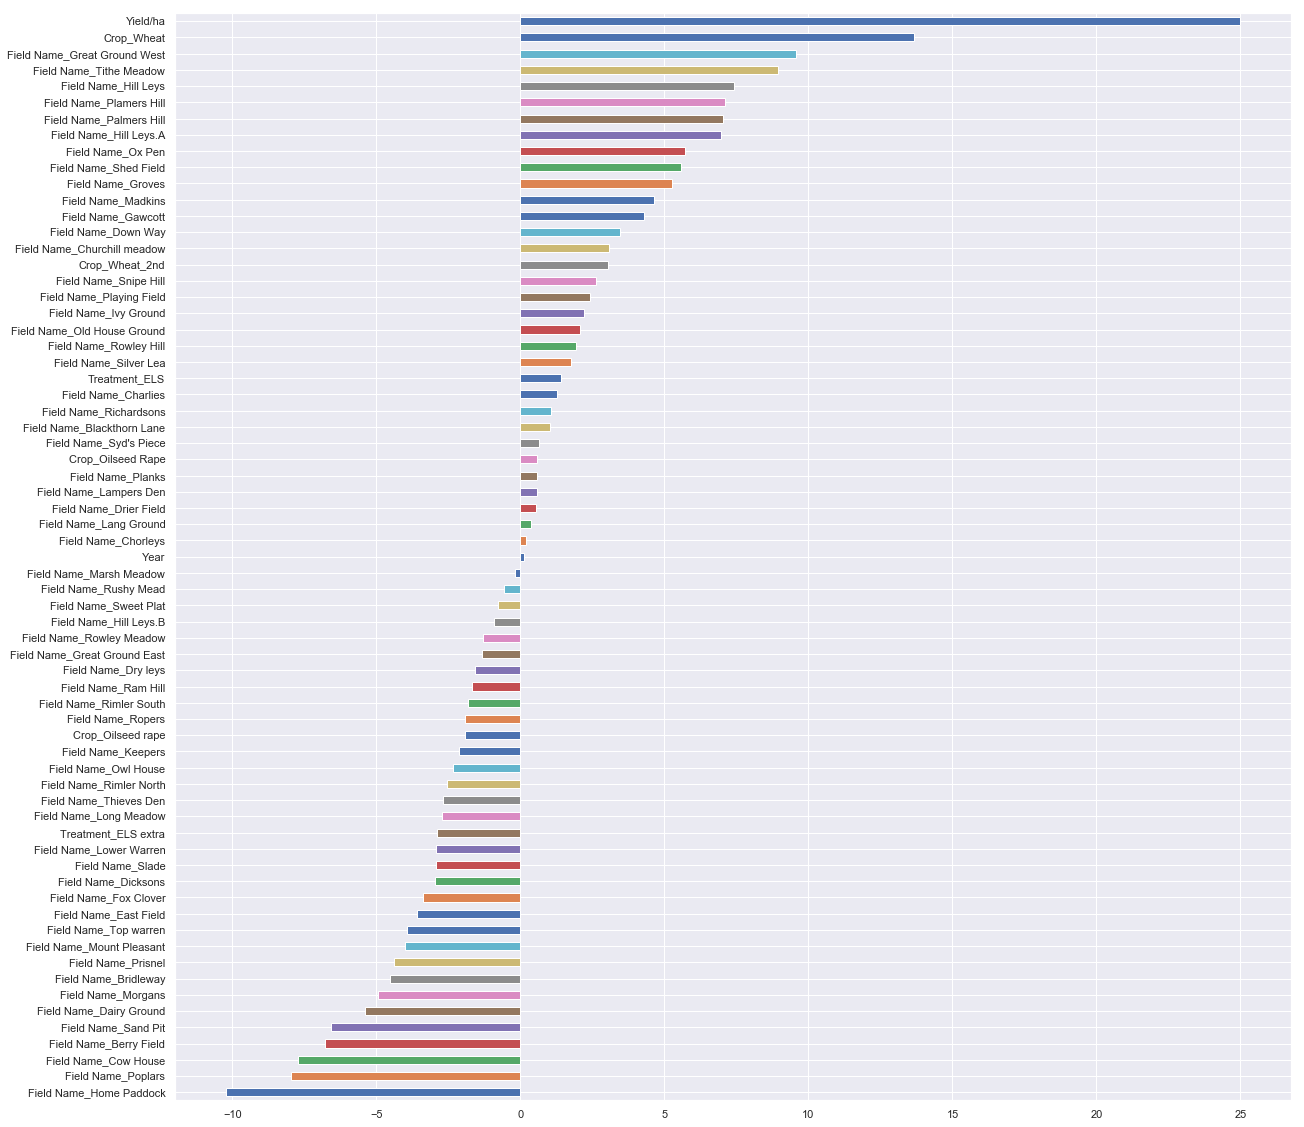

In [32]:
plt.figure(figsize=(20,20))
df_coef1['coefficients'].sort_values().plot(kind='barh');

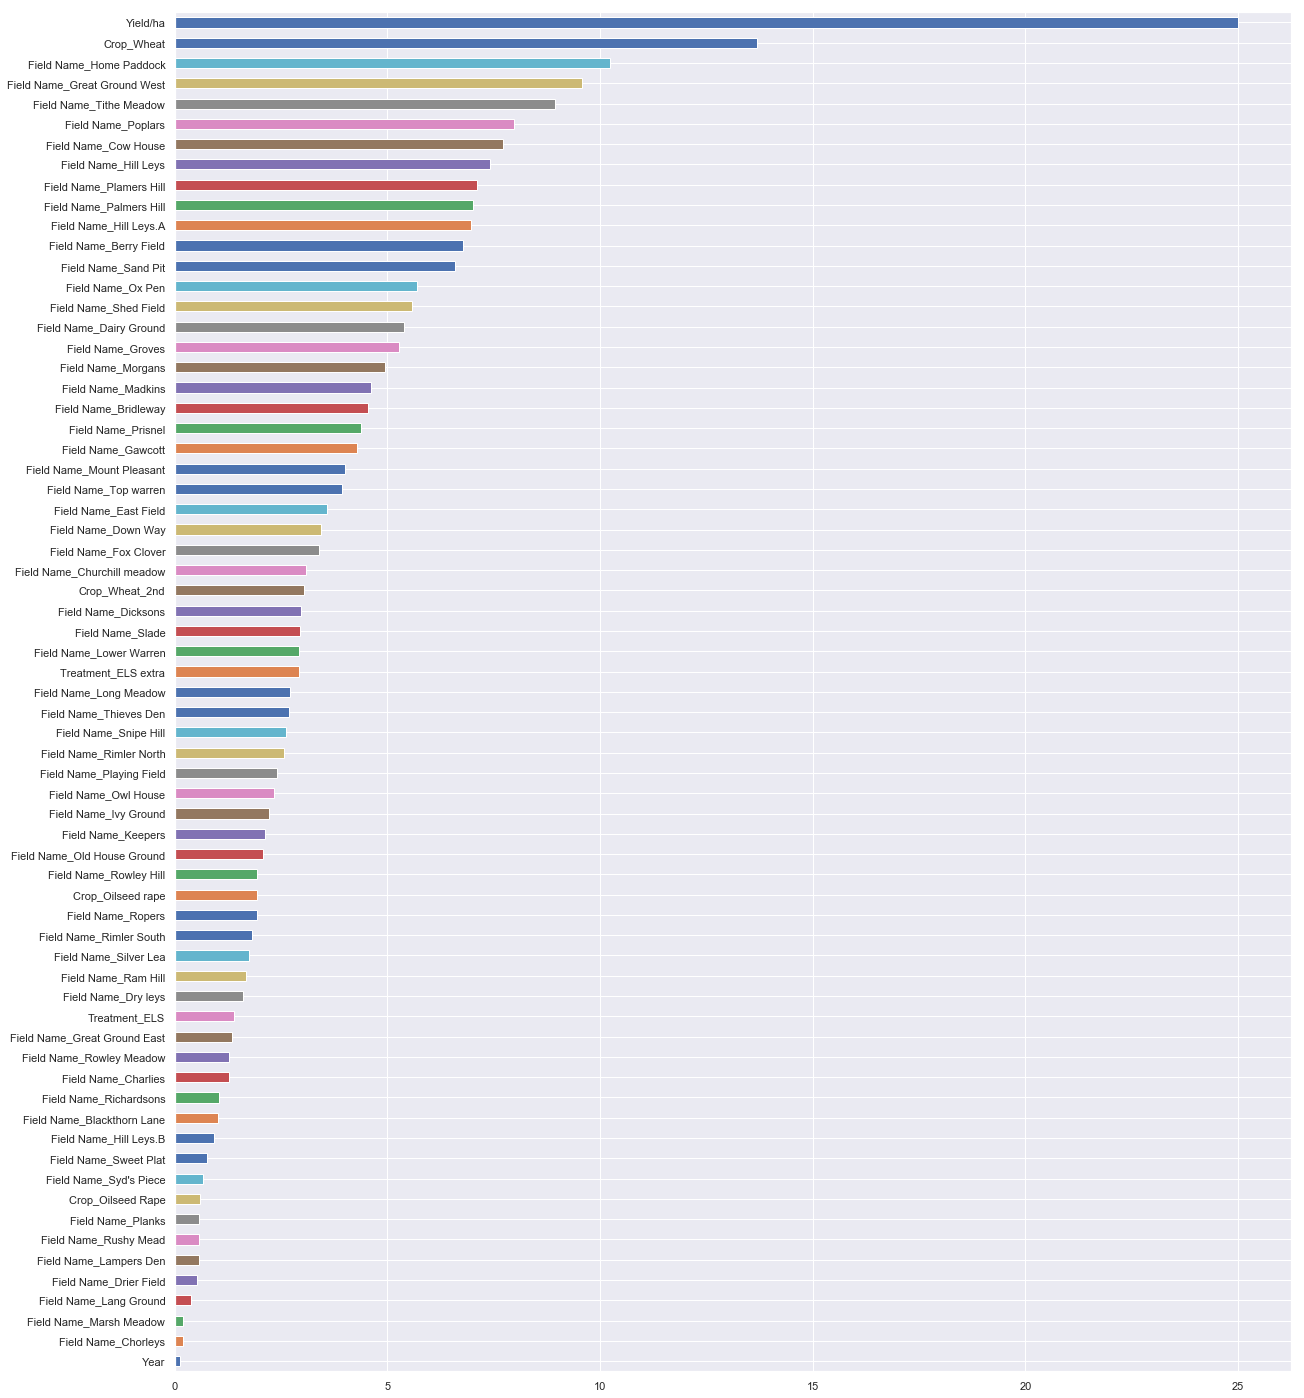

In [33]:
df_coef1['coef_abs'].sort_values().plot(kind='barh');

#### LassoCV time

In [34]:
model = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5)
model.fit(X_train, y_train)
print('Best alpha:', model.alpha_)
print('Training score:', model.score(X_train, y_train))
print("Test Score:", model.score(X_test, y_test))

Best alpha: 0.3593813663804626
Training score: 0.9003893685294688
Test Score: 0.7940253629783581


In [35]:
df_coef2 = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
df_coef2['coef_abs'] = df_coef2.coefficients.abs()
df_coef2

coefficients   coef_abs
Year                             -0.810727   0.810727
Yield/ha                         36.086185  36.086185
Treatment_ELS                     0.000000   0.000000
Treatment_ELS extra              -0.264558   0.264558
Field Name_Berry Field           -7.885985   7.885985
Field Name_Blackthorn Lane        1.244553   1.244553
Field Name_Bridleway             -5.296838   5.296838
Field Name_Charlies               1.920641   1.920641
Field Name_Chorleys               0.000000   0.000000
Field Name_Churchill meadow       2.635644   2.635644
Field Name_Cow House             -7.296697   7.296697
Field Name_Dairy Ground          -4.777092   4.777092
Field Name_Dicksons              -2.252642   2.252642
Field Name_Down Way               3.692871   3.692871
Field Name_Drier Field           -0.000000   0.000000
Field Name_Dry leys              -0.831637   0.831637
Field Name_East Field            -3.447486   3.447486
Field Name_Fox Clover            -3.151168   3.151168
Field Name_Gawcott                3.416910   3.416910
Field Name_Great Ground East     -0.436090   0.436090
Field Name_Great Ground West     10.342651  10.342651
Field Name_Groves                 5.912287   5.912287
Field Name_Hill Leys              7.446805   7.446805
Field Name_Hill Leys.A            6.803706   6.803706
Field Name_Hill Leys.B           -0.055860   0.055860
Field Name_Home Paddock         -11.599707  11.599707
Field Name_Ivy Ground             2.187895   2.187895
Field Name_Keepers               -2.801540   2.801540
Field Name_Lampers Den            0.924299   0.924299
Field Name_Lang Ground            0.164067   0.164067
...                                    ...        ...
Field Name_Owl House             -2.888128   2.888128
Field Name_Ox Pen                 6.440619   6.440619
Field Name_Palmers Hill           6.406754   6.406754
Field Name_Plamers Hill           6.691195   6.691195
Field Name_Planks                 1.247139   1.247139
Field Name_Playing Field          2.505504   2.505504
Field Name_Poplars               -8.978794   8.978794
Field Name_Prisnel               -3.959098   3.959098
Field Name_Ram Hill              -0.926049   0.926049
Field Name_Richardsons            0.568501   0.568501
Field Name_Rimler North          -2.313861   2.313861
Field Name_Rimler South          -1.186109   1.186109
Field Name_Ropers                -2.476575   2.476575
Field Name_Rowley Hill            1.053535   1.053535
Field Name_Rowley Meadow         -1.046723   1.046723
Field Name_Rushy Mead            -0.000000   0.000000
Field Name_Sand Pit              -5.985499   5.985499
Field Name_Shed Field             5.876058   5.876058
Field Name_Silver Lea             0.816427   0.816427
Field Name_Slade                 -3.549613   3.549613
Field Name_Snipe Hill             2.554001   2.554001
Field Name_Sweet Plat            -0.000000   0.000000
Field Name_Syd's Piece            1.337529   1.337529
Field Name_Thieves Den           -2.203286   2.203286
Field Name_Tithe Meadow           9.816576   9.816576
Field Name_Top warren            -3.261324   3.261324
Crop_Oilseed Rape                 0.000000   0.000000
Crop_Oilseed rape                -0.000000   0.000000
Crop_Wheat                        5.769280   5.769280
Crop_Wheat_2nd                    0.962866   0.962866

[67 rows x 2 columns]

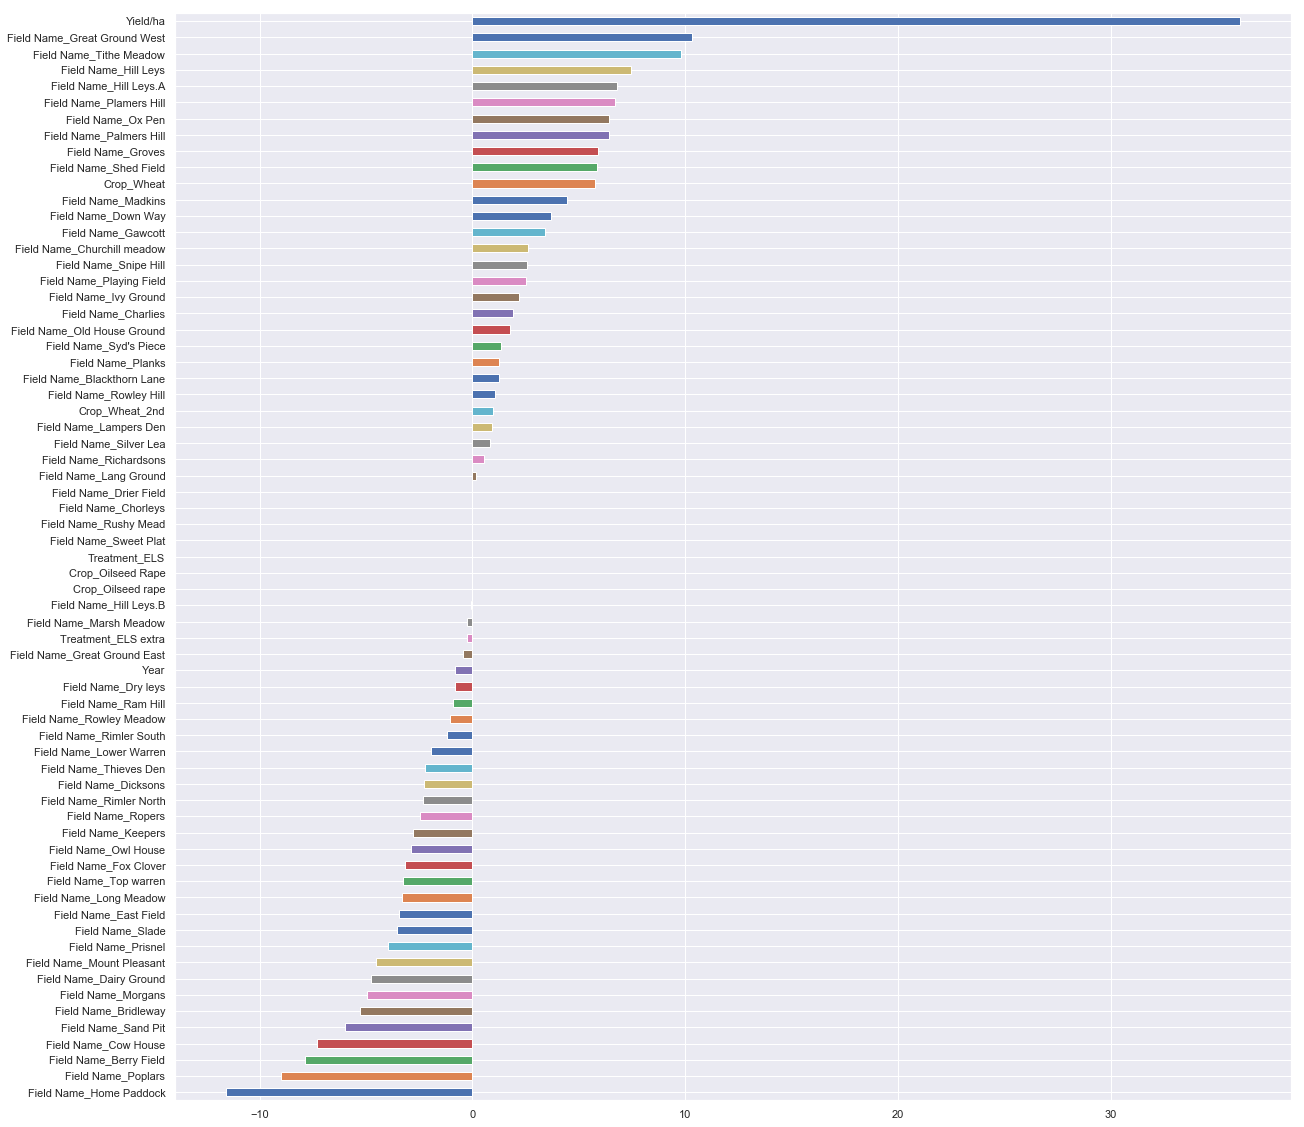

In [36]:
plt.figure(figsize=(20,20))
df_coef2['coefficients'].sort_values().plot(kind='barh');

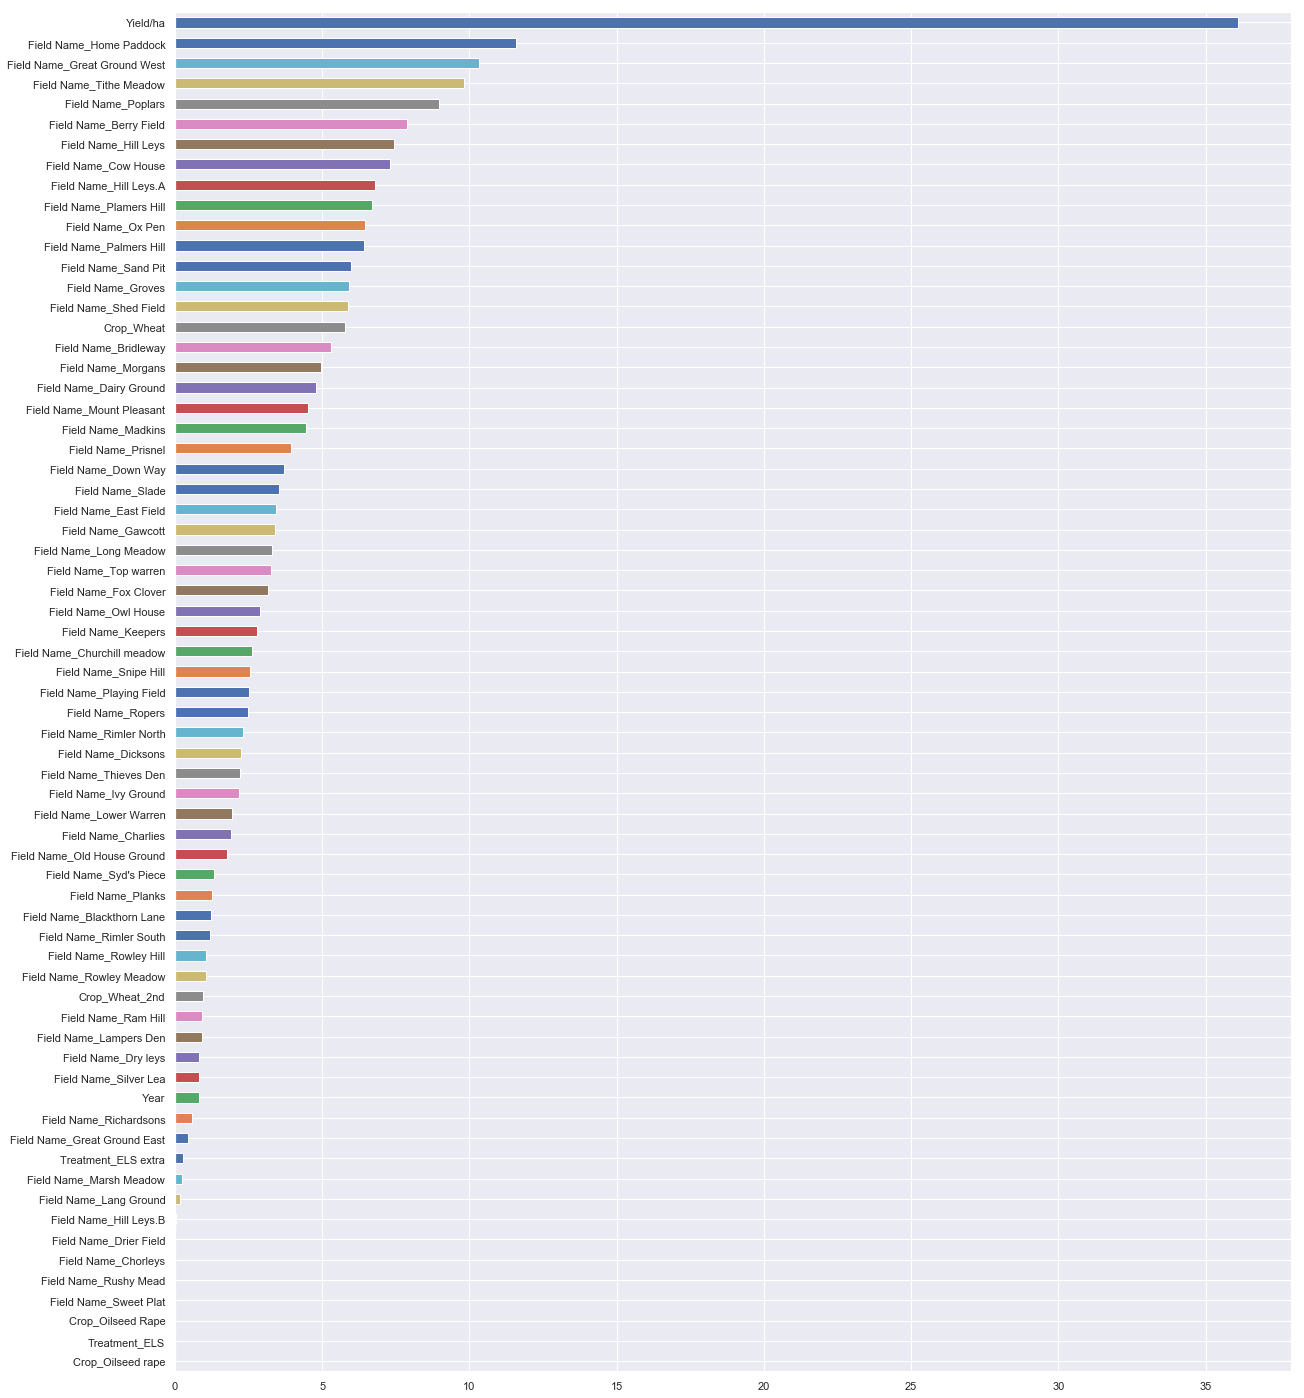

In [37]:
df_coef2['coef_abs'].sort_values().plot(kind='barh');

#### ElasticNetCV

In [38]:
model = ElasticNetCV(alphas=np.logspace(-4, 4, 10), cv=5)

In [39]:
model.fit(X_train, y_train)
print('Best alpha:', model.alpha_)
print('Training score:', model.score(X_train, y_train))
print("Test Score:", model.score(X_test, y_test))

Best alpha: 0.046415888336127774
Training score: 0.9023800706036298
Test Score: 0.7960549589278101


In [40]:
df_coef3 = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
df_coef3['coef_abs'] = df_coef3.coefficients.abs()
df_coef3

coefficients   coef_abs
Year                             -0.371122   0.371122
Yield/ha                         30.303619  30.303619
Treatment_ELS                     1.792333   1.792333
Treatment_ELS extra              -3.338919   3.338919
Field Name_Berry Field           -7.445681   7.445681
Field Name_Blackthorn Lane        0.628680   0.628680
Field Name_Bridleway             -4.944886   4.944886
Field Name_Charlies               1.196177   1.196177
Field Name_Chorleys               0.000000   0.000000
Field Name_Churchill meadow       3.281330   3.281330
Field Name_Cow House             -8.338767   8.338767
Field Name_Dairy Ground          -5.699258   5.699258
Field Name_Dicksons              -3.389642   3.389642
Field Name_Down Way               3.297442   3.297442
Field Name_Drier Field            0.479526   0.479526
Field Name_Dry leys              -1.965398   1.965398
Field Name_East Field            -4.133947   4.133947
Field Name_Fox Clover            -3.907574   3.907574
Field Name_Gawcott                4.319016   4.319016
Field Name_Great Ground East     -1.288650   1.288650
Field Name_Great Ground West     10.089476  10.089476
Field Name_Groves                 5.594174   5.594174
Field Name_Hill Leys              7.942780   7.942780
Field Name_Hill Leys.A            7.391815   7.391815
Field Name_Hill Leys.B           -0.458325   0.458325
Field Name_Home Paddock         -11.153487  11.153487
Field Name_Ivy Ground             2.139230   2.139230
Field Name_Keepers               -2.358712   2.358712
Field Name_Lampers Den            0.568355   0.568355
Field Name_Lang Ground            0.129251   0.129251
...                                    ...        ...
Field Name_Owl House             -2.519844   2.519844
Field Name_Ox Pen                 5.775513   5.775513
Field Name_Palmers Hill           7.189508   7.189508
Field Name_Plamers Hill           7.371851   7.371851
Field Name_Planks                 0.497160   0.497160
Field Name_Playing Field          2.496598   2.496598
Field Name_Poplars               -8.563968   8.563968
Field Name_Prisnel               -5.055575   5.055575
Field Name_Ram Hill              -1.721782   1.721782
Field Name_Richardsons            1.140673   1.140673
Field Name_Rimler North          -2.982873   2.982873
Field Name_Rimler South          -2.289397   2.289397
Field Name_Ropers                -2.101813   2.101813
Field Name_Rowley Hill            1.896877   1.896877
Field Name_Rowley Meadow         -1.512310   1.512310
Field Name_Rushy Mead            -0.928277   0.928277
Field Name_Sand Pit              -7.245024   7.245024
Field Name_Shed Field             5.493470   5.493470
Field Name_Silver Lea             1.647825   1.647825
Field Name_Slade                 -3.292638   3.292638
Field Name_Snipe Hill             3.016070   3.016070
Field Name_Sweet Plat            -0.749293   0.749293
Field Name_Syd's Piece            0.516453   0.516453
Field Name_Thieves Den           -3.163185   3.163185
Field Name_Tithe Meadow           9.118110   9.118110
Field Name_Top warren            -4.029539   4.029539
Crop_Oilseed Rape                 0.958004   0.958004
Crop_Oilseed rape                -0.388571   0.388571
Crop_Wheat                       11.121321  11.121321
Crop_Wheat_2nd                    2.507605   2.507605

[67 rows x 2 columns]

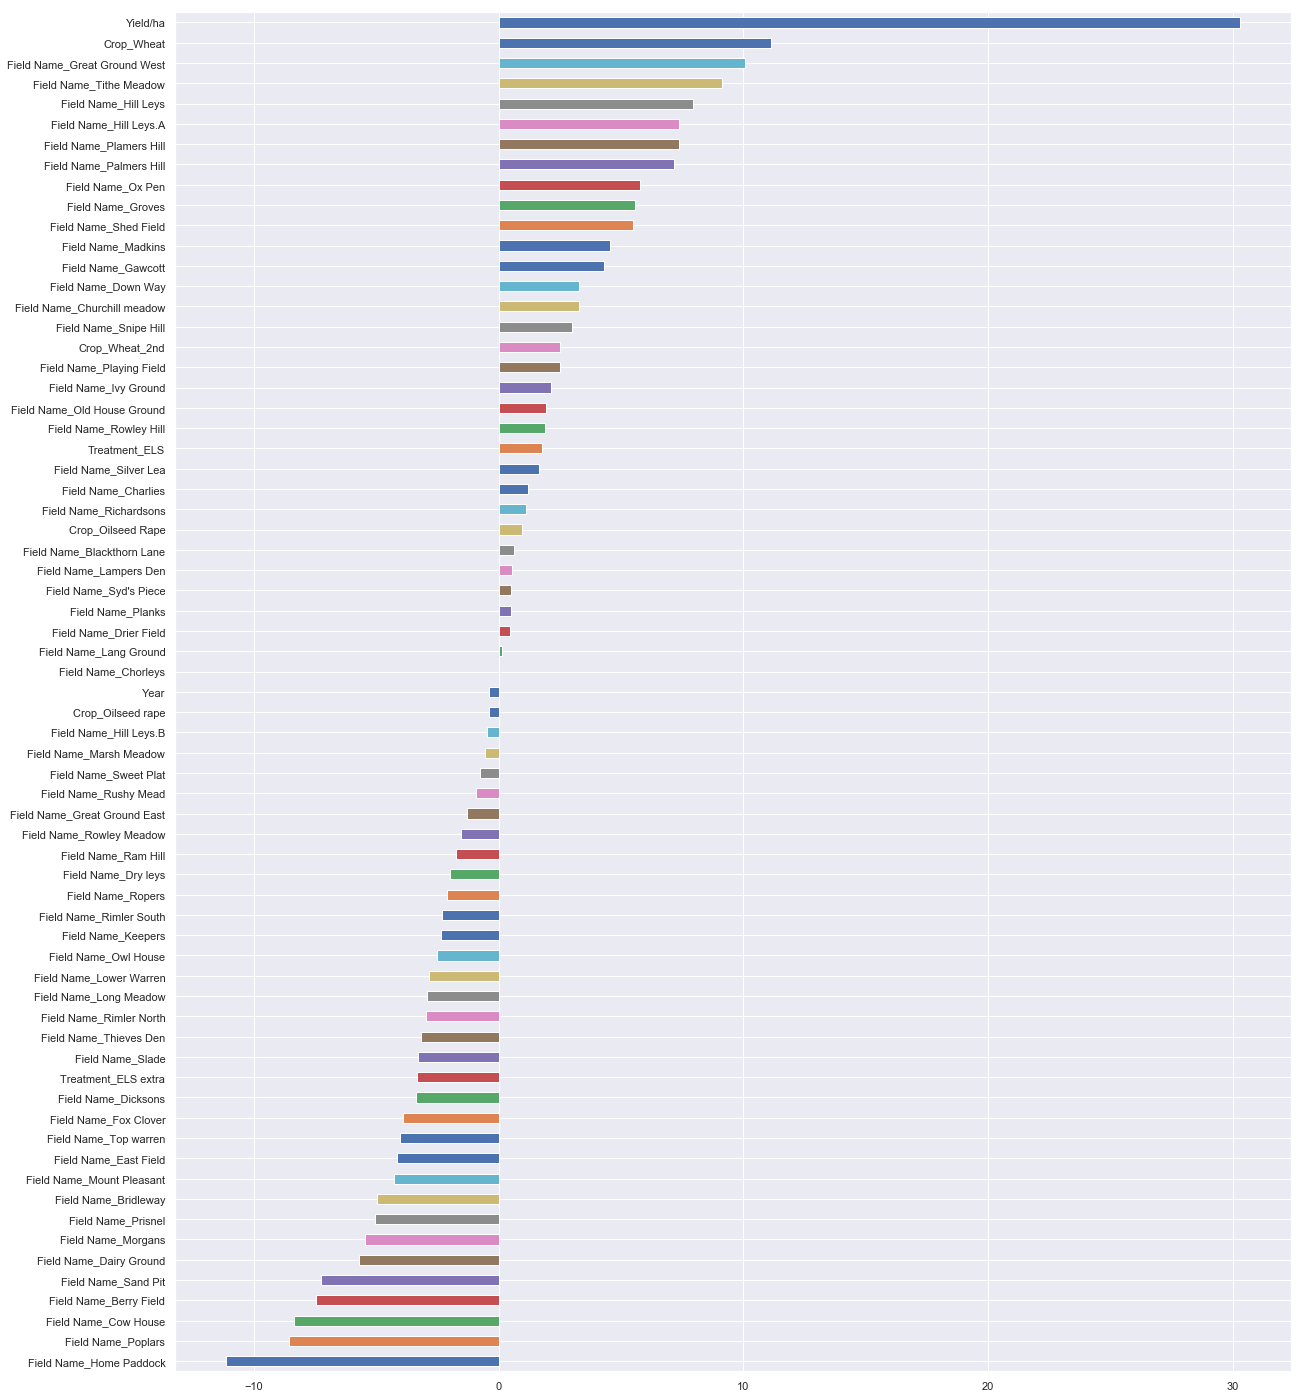

In [41]:
df_coef3['coefficients'].sort_values().plot(kind='barh');

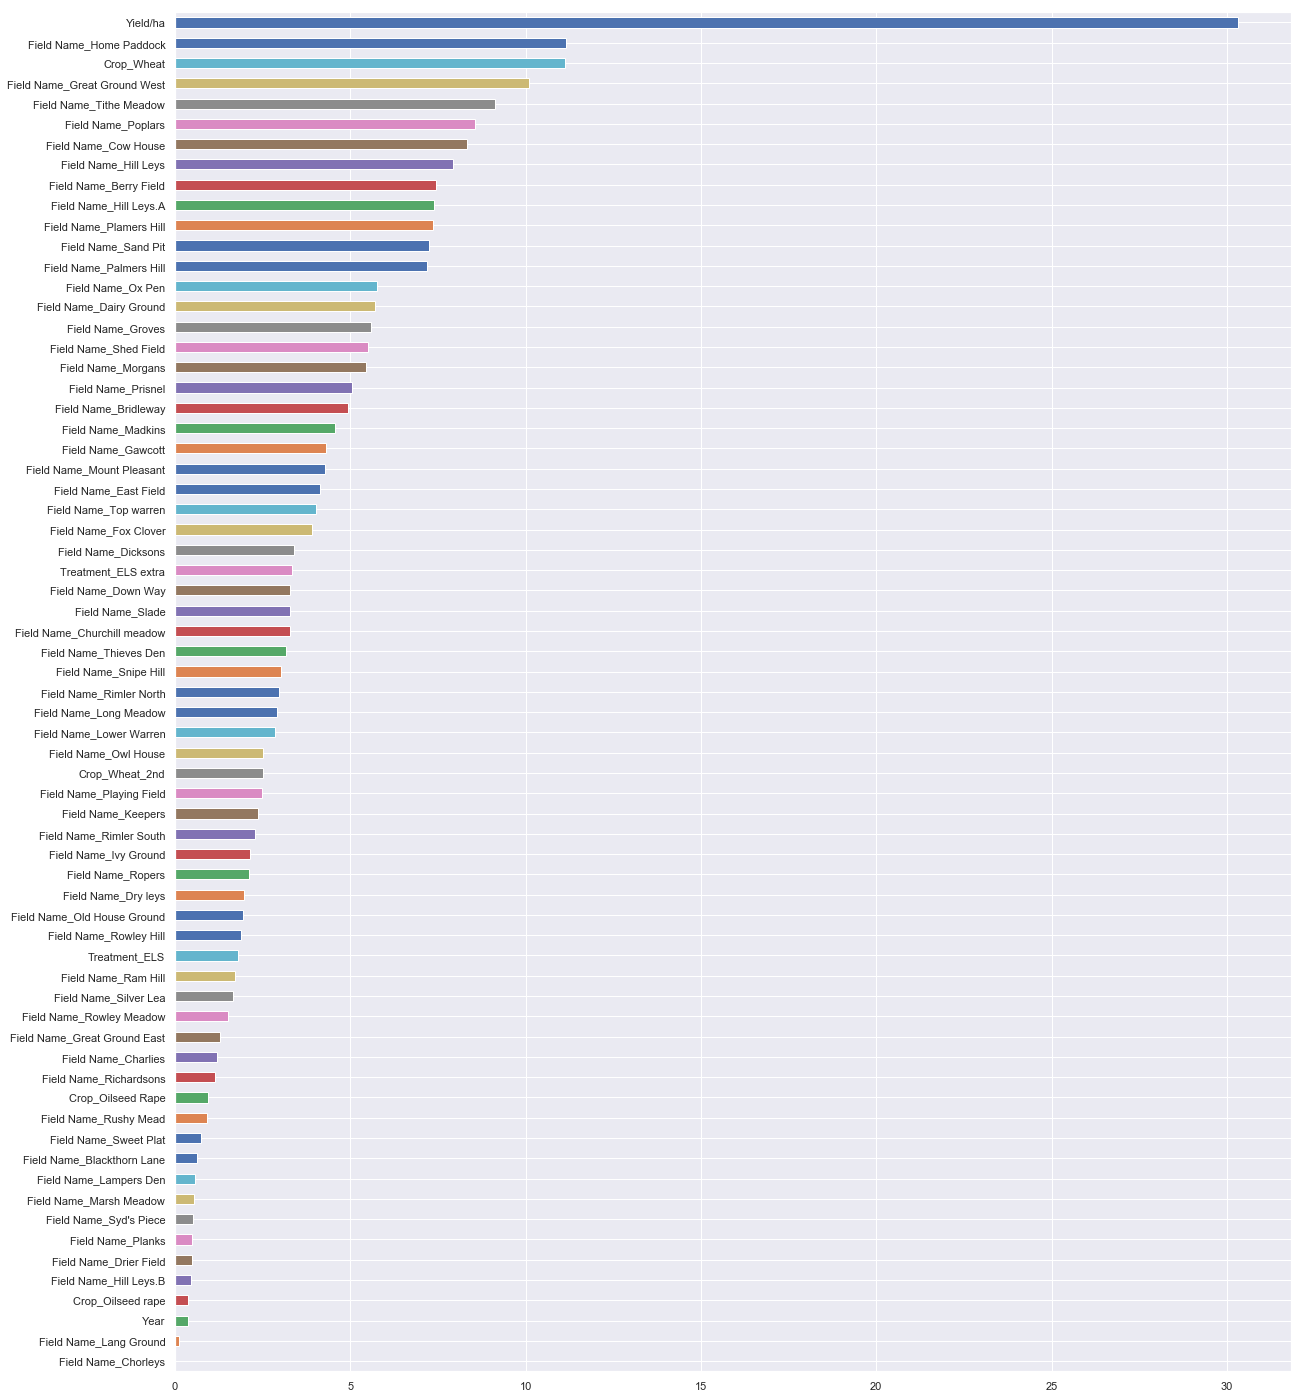

In [42]:
df_coef3['coef_abs'].sort_values().plot(kind='barh');

### Decision Tree and Random Forest Regression

In [43]:
dt = DecisionTreeRegressor()

In [44]:
get_model_scores(DecisionTreeRegressor(max_depth=5), X_train, y_train, X_test, y_test)

Cross-validated training scores: [0.67991434 0.44403475 0.52041269 0.39254613 0.56897818]
Mean cross-validated training score: 0.5211772187919632
Training Score: 0.6693169100112084
Test Score: 0.5183132813019729


DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [45]:
def plot_dt(dt, feature_names=None):
    print('Max depth:', dt.max_depth)
    dot_data = StringIO() 
    export_graphviz(dt, 
                    out_file=dot_data,  
                    filled=True, 
                    rounded=True,
                    special_characters=True,
                    feature_names=feature_names
                   )  

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    return Image(graph.create_png()) 

In [46]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Max depth: None


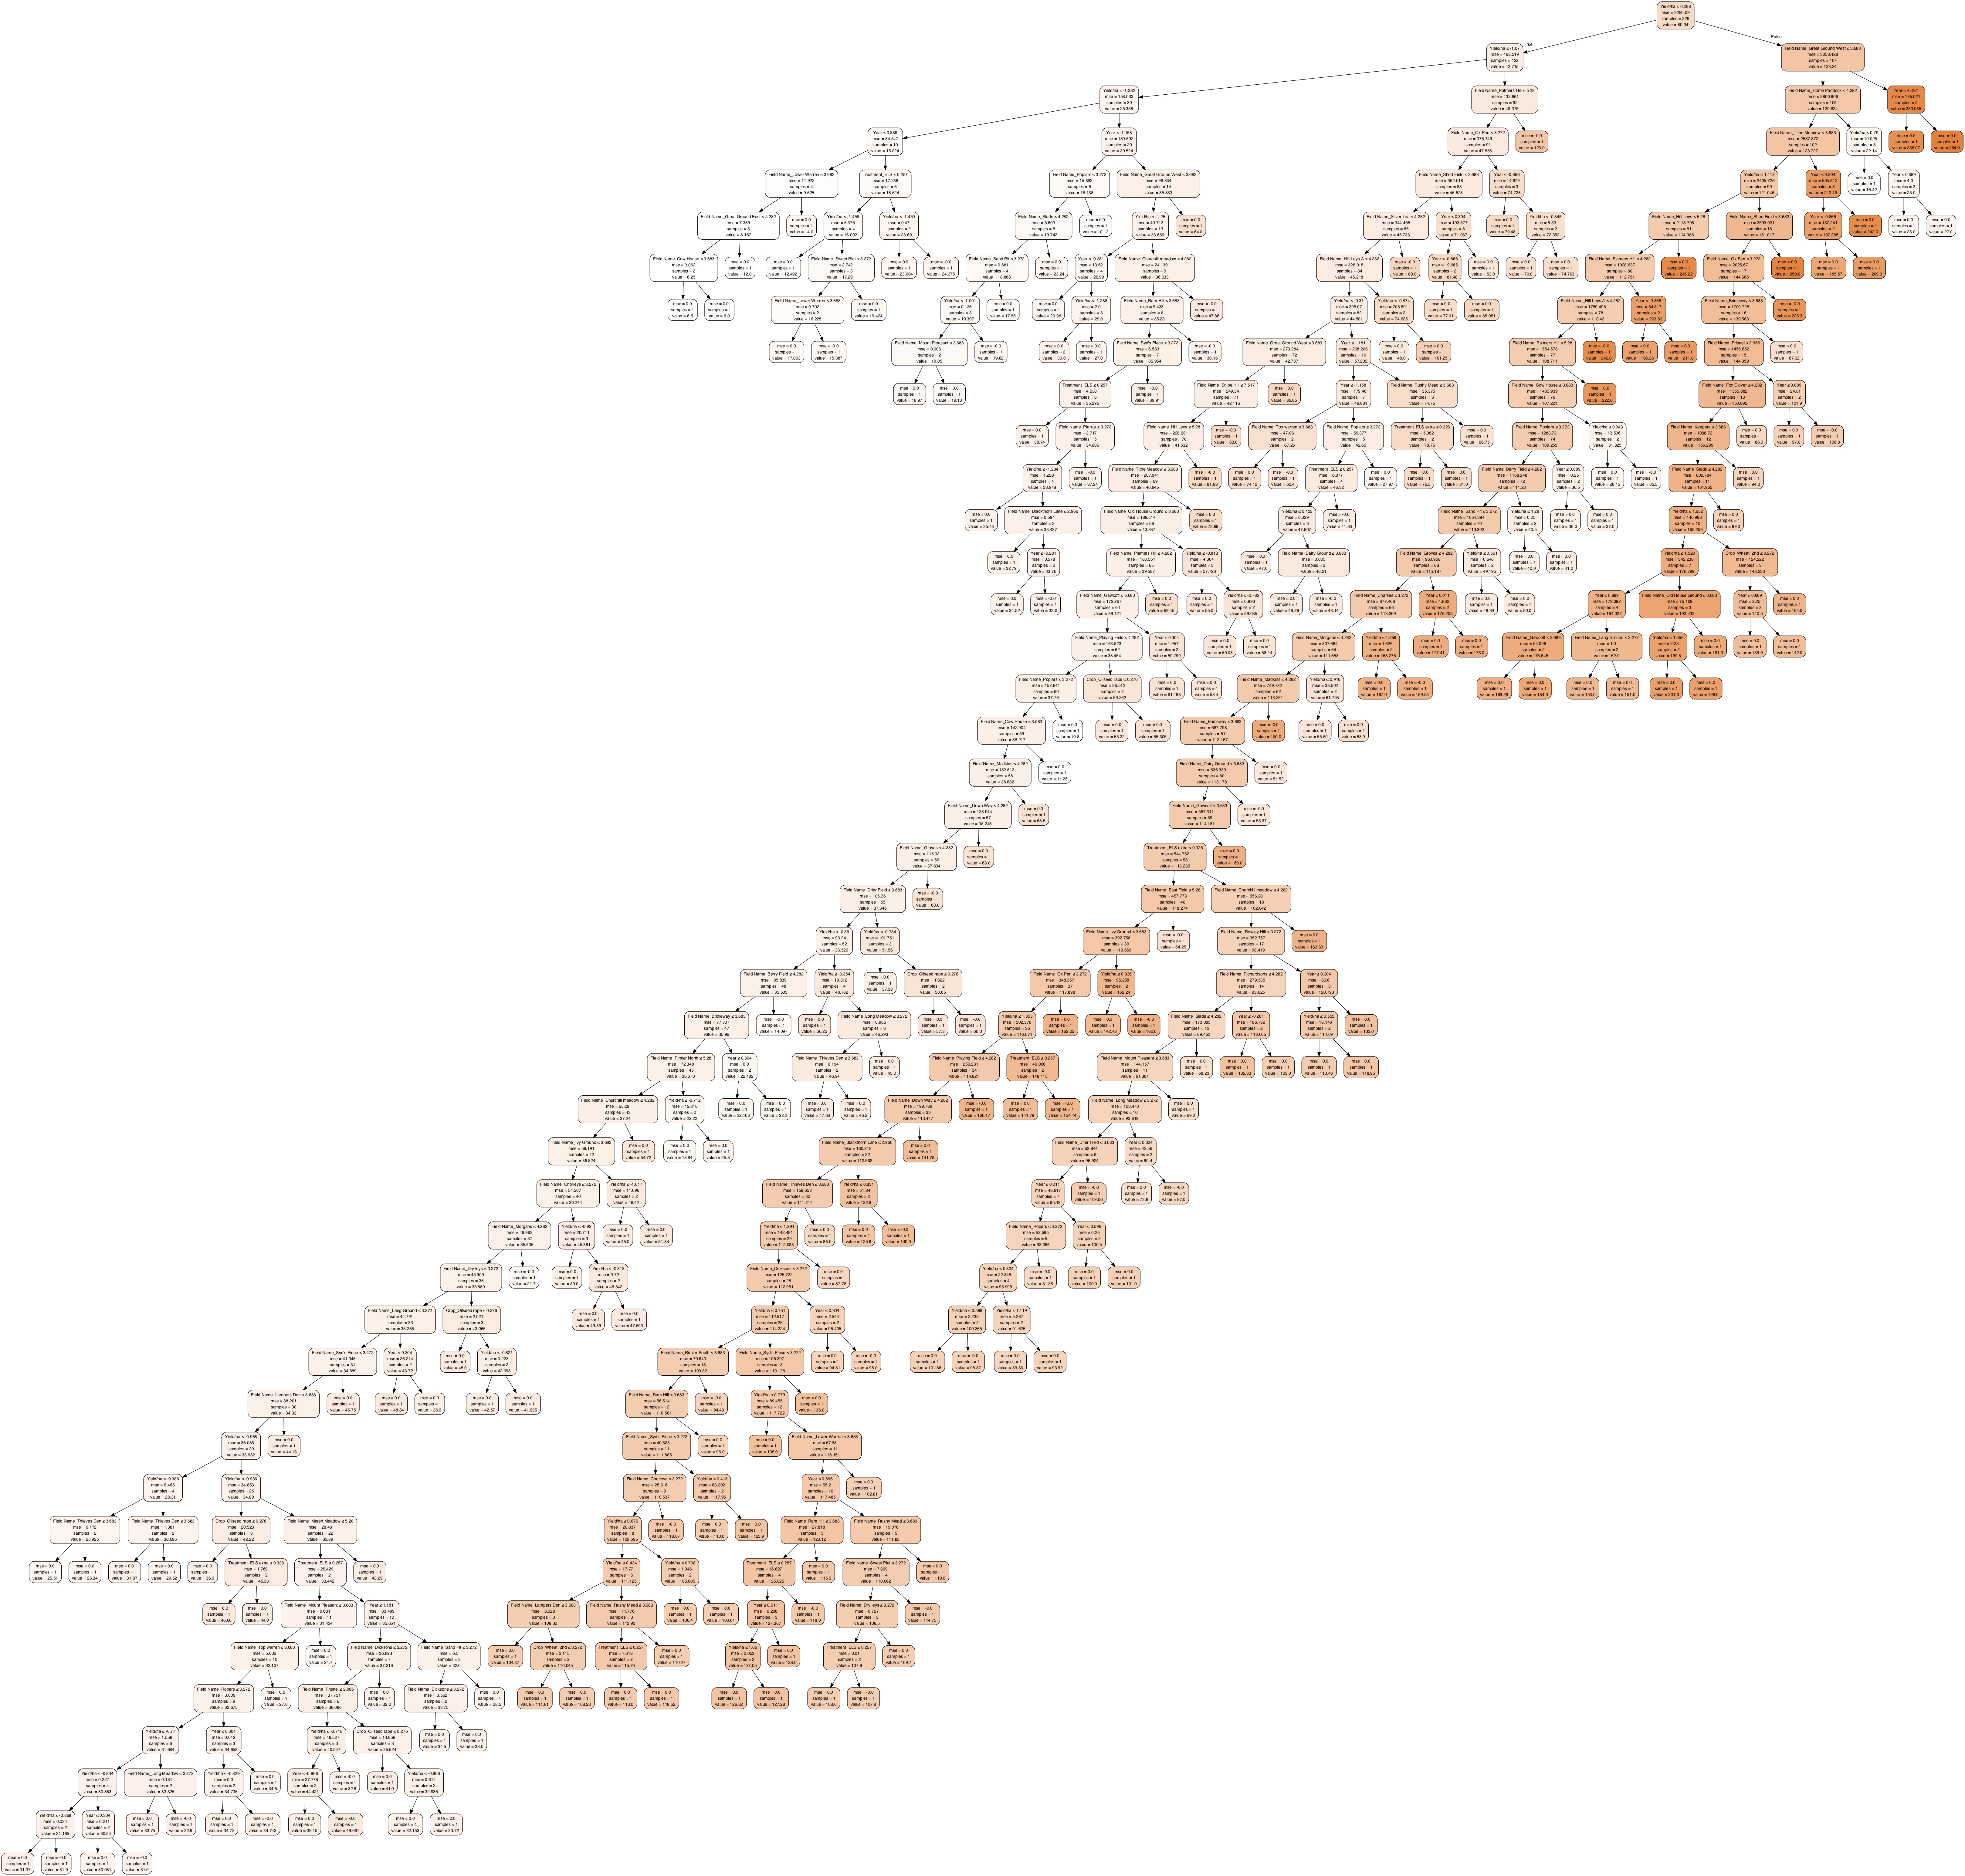

In [47]:
plot_dt(dt, feature_names=hill_X.columns)

In [48]:
kfolds = 5
model = DecisionTreeRegressor(random_state=1)

In [49]:
params = {'max_depth': [1, 2, 3, 4, 5, 6],
          #, 'max_features':[1,2,3,4],
          'max_leaf_nodes': [5, 6, 7, 8, 9, 10],
          'min_samples_leaf': [1, 2, 3, 4]
          #'min_samples_split':[1,2,3,4]
          }

gs = GridSearchCV(model, param_grid=params, cv=kfolds, n_jobs = -1)
gs.fit(X_train, y_train)

model = gs.best_estimator_
print(gs.best_estimator_)
print('R2 training: ', gs.score(X_train, y_train))
print('R2 test: ', gs.score(X_test, y_test))

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')
R2 training:  0.6951065998313777
R2 test:  0.5845264970967443


In [50]:
gs_mse = GridSearchCV(model, param_grid=params, cv=kfolds,
                      scoring='neg_mean_squared_error')
gs_mse.fit(X_train, y_train)

print(gs_mse.best_estimator_)
print('MSE training: ', -gs_mse.score(X_train, y_train))
print('MSE test: ', -gs_mse.score(X_test, y_test))

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')
MSE training:  1003.1265805958225
MSE test:  1942.3482101047275


In [51]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [52]:
df_coef = pd.DataFrame(model.feature_importances_, index=X_train.columns,
                       columns=['feature importances'])


In [53]:
df_coef_ = pd.DataFrame(lr.coef_, index=X_train.columns,
                       columns=['coefficients'])

In [54]:
df_coef['coef_abs'] = df_coef_.coefficients.abs()


In [55]:
df_coef.sort_values('feature importances', ascending = False)

feature importances      coef_abs
Yield/ha                                 0.766403  3.418232e+01
Field Name_Great Ground West             0.062566  2.496655e+14
Field Name_Home Paddock                  0.057427  4.900862e+14
Field Name_Tithe Meadow                  0.046187  9.187500e+00
Field Name_Hill Leys                     0.033093  4.010380e+14
Field Name_Shed Field                    0.023574  5.046875e+00
Field Name_Palmers Hill                  0.010750  4.010380e+14
Field Name_Rimler North                  0.000000  3.515625e+00
Field Name_Richardsons                   0.000000  4.900862e+14
Field Name_Ram Hill                      0.000000  2.496655e+14
Year                                     0.000000  1.449702e+00
Field Name_Prisnel                       0.000000  5.453125e+00
Field Name_Rimler South                  0.000000  2.500000e+00
Field Name_Playing Field                 0.000000  2.166966e+14
Field Name_Planks                        0.000000  3.593750e-01
Field Name_Plamers Hill                  0.000000  4.900862e+14
Field Name_Ox Pen                        0.000000  5.476562e+00
Field Name_Poplars                       0.000000  6.298927e+14
Field Name_Rowley Hill                   0.000000  6.298927e+14
Field Name_Ropers                        0.000000  6.298927e+14
Field Name_Old House Ground              0.000000  2.496655e+14
Field Name_Rowley Meadow                 0.000000  5.646494e+14
Field Name_Rushy Mead                    0.000000  1.320312e+00
Field Name_Sand Pit                      0.000000  7.746094e+00
Field Name_Silver Lea                    0.000000  4.900862e+14
Field Name_Slade                         0.000000  4.900862e+14
Field Name_Snipe Hill                    0.000000  2.842006e+14
Field Name_Sweet Plat                    0.000000  2.785135e+14
Field Name_Syd's Piece                   0.000000  7.031250e-01
Field Name_Thieves Den                   0.000000  3.593750e+00
...                                           ...           ...
Field Name_Dry leys                      0.000000  2.703125e+00
Treatment_ELS                            0.000000  9.228996e+14
Treatment_ELS extra                      0.000000  1.142948e+15
Field Name_Berry Field                   0.000000  4.900862e+14
Field Name_Blackthorn Lane               0.000000  8.780228e-02
Field Name_Bridleway                     0.000000  5.646494e+14
Field Name_Charlies                      0.000000  1.278116e+00
Field Name_Chorleys                      0.000000  2.785135e+14
Field Name_Churchill meadow              0.000000  4.900862e+14
Field Name_Cow House                     0.000000  8.953125e+00
Field Name_Dairy Ground                  0.000000  2.496655e+14
Field Name_Dicksons                      0.000000  3.875000e+00
Field Name_Down Way                      0.000000  3.085938e+00
Field Name_Drier Field                   0.000000  5.646494e+14
Field Name_East Field                    0.000000  4.808594e+00
Field Name_Morgans                       0.000000  2.166966e+14
Field Name_Fox Clover                    0.000000  4.093750e+00
Field Name_Gawcott                       0.000000  5.646494e+14
Field Name_Great Ground East             0.000000  2.166966e+14
Field Name_Groves                        0.000000  2.166966e+14
Field Name_Hill Leys.A                   0.000000  4.900862e+14
Field Name_Hill Leys.B                   0.000000  2.842006e+14
Field Name_Ivy Ground                    0.000000  2.496655e+14
Field Name_Keepers                       0.000000  5.646494e+14
Field Name_Lampers Den                   0.000000  2.496655e+14
Field Name_Lang Ground                   0.000000  2.785135e+14
Field Name_Long Meadow                   0.000000  6.298927e+14
Field Name_Lower Warren                  0.000000  2.496655e+14
Field Name_Madkins                       0.000000  2.166966e+14
Crop_Wheat_2nd                           0.000000  1.960938e+00

[67 rows x 2 columns]

In [56]:
df_coef.corr(method='spearman')

feature importances  coef_abs
feature importances             1.000000  0.013154
coef_abs                        0.013154  1.000000

### Random forest correlations

In [60]:
model_f = RandomForestRegressor(random_state=1)

In [61]:
model_f.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [62]:
df_coef_f = pd.DataFrame(model_f.feature_importances_, index=X_train.columns,
                       columns=['feature importances'])
df_coef_f['coef_abs'] = df_coef_.coefficients.abs()

In [63]:
df_coef_f.sort_values('feature importances', ascending = False)

feature importances      coef_abs
Yield/ha                                 0.586841  3.418232e+01
Field Name_Great Ground West             0.051257  2.496655e+14
Field Name_Tithe Meadow                  0.037666  9.187500e+00
Field Name_Plamers Hill                  0.028674  4.900862e+14
Field Name_Hill Leys.A                   0.021851  4.900862e+14
Field Name_Shed Field                    0.021746  5.046875e+00
Field Name_Hill Leys                     0.019713  4.010380e+14
Field Name_Ox Pen                        0.019200  5.476562e+00
Field Name_Poplars                       0.016592  6.298927e+14
Field Name_Home Paddock                  0.016563  4.900862e+14
Treatment_ELS extra                      0.016108  1.142948e+15
Field Name_Groves                        0.015121  2.166966e+14
Year                                     0.014428  1.449702e+00
Field Name_Palmers Hill                  0.013451  4.010380e+14
Field Name_Gawcott                       0.012362  5.646494e+14
Field Name_Cow House                     0.010306  8.953125e+00
Field Name_Madkins                       0.009938  2.166966e+14
Field Name_Sand Pit                      0.009190  7.746094e+00
Field Name_Berry Field                   0.008450  4.900862e+14
Field Name_Morgans                       0.006474  2.166966e+14
Field Name_Dairy Ground                  0.005824  2.496655e+14
Field Name_Silver Lea                    0.004676  4.900862e+14
Field Name_Down Way                      0.004358  3.085938e+00
Field Name_Churchill meadow              0.003910  4.900862e+14
Field Name_Ivy Ground                    0.003861  2.496655e+14
Field Name_East Field                    0.003551  4.808594e+00
Field Name_Prisnel                       0.003263  5.453125e+00
Field Name_Bridleway                     0.002942  5.646494e+14
Field Name_Charlies                      0.002839  1.278116e+00
Field Name_Blackthorn Lane               0.002346  8.780228e-02
...                                           ...           ...
Field Name_Rowley Hill                   0.001132  6.298927e+14
Field Name_Dicksons                      0.000921  3.875000e+00
Crop_Wheat_2nd                           0.000917  1.960938e+00
Field Name_Lang Ground                   0.000892  2.785135e+14
Field Name_Keepers                       0.000882  5.646494e+14
Field Name_Slade                         0.000871  4.900862e+14
Field Name_Top warren                    0.000755  2.496655e+14
Field Name_Rimler North                  0.000733  3.515625e+00
Field Name_Syd's Piece                   0.000731  7.031250e-01
Field Name_Chorleys                      0.000731  2.785135e+14
Field Name_Rimler South                  0.000724  2.500000e+00
Field Name_Mount Pleasant                0.000693  5.646494e+14
Field Name_Thieves Den                   0.000613  3.593750e+00
Field Name_Drier Field                   0.000609  5.646494e+14
Field Name_Sweet Plat                    0.000545  2.785135e+14
Field Name_Rushy Mead                    0.000539  1.320312e+00
Field Name_Dry leys                      0.000537  2.703125e+00
Field Name_Lower Warren                  0.000451  2.496655e+14
Field Name_Marsh Meadow                  0.000355  1.773230e+14
Field Name_Long Meadow                   0.000301  6.298927e+14
Crop_Wheat                               0.000293  7.625000e+00
Field Name_Owl House                     0.000270  6.298927e+14
Crop_Oilseed rape                        0.000244  3.125000e-01
Field Name_Great Ground East             0.000215  2.166966e+14
Field Name_Richardsons                   0.000209  4.900862e+14
Field Name_Ram Hill                      0.000196  2.496655e+14
Field Name_Rowley Meadow                 0.000107  5.646494e+14
Field Name_Lampers Den                   0.000090  2.496655e+14
Crop_Oilseed Rape                        0.000023  1.250000e+00
Field Name_Hill Leys.B                   0.000007  2.842006e+14

[67 rows x 2 columns]

In [64]:
df_coef_f.corr(method='spearman')

feature importances  coef_abs
feature importances             1.000000  0.058784
coef_abs                        0.058784  1.000000

In [66]:
df_f = df_coef_f[df_coef_f['feature importances'] > 0.0164]

In [68]:
df_f.corr(method='spearman')

feature importances  coef_abs
feature importances             1.000000 -0.381818
coef_abs                       -0.381818  1.000000

In [71]:
colors = df_coef3.coefficients.sort_values(ascending=False).map(lambda x: 'r' if x>0 else 'b').values
colors

array(['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'b', 'b', 'b', 'b', 'b', 'b', 'b',
       'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b',
       'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b',
       'b', 'b'], dtype=object)

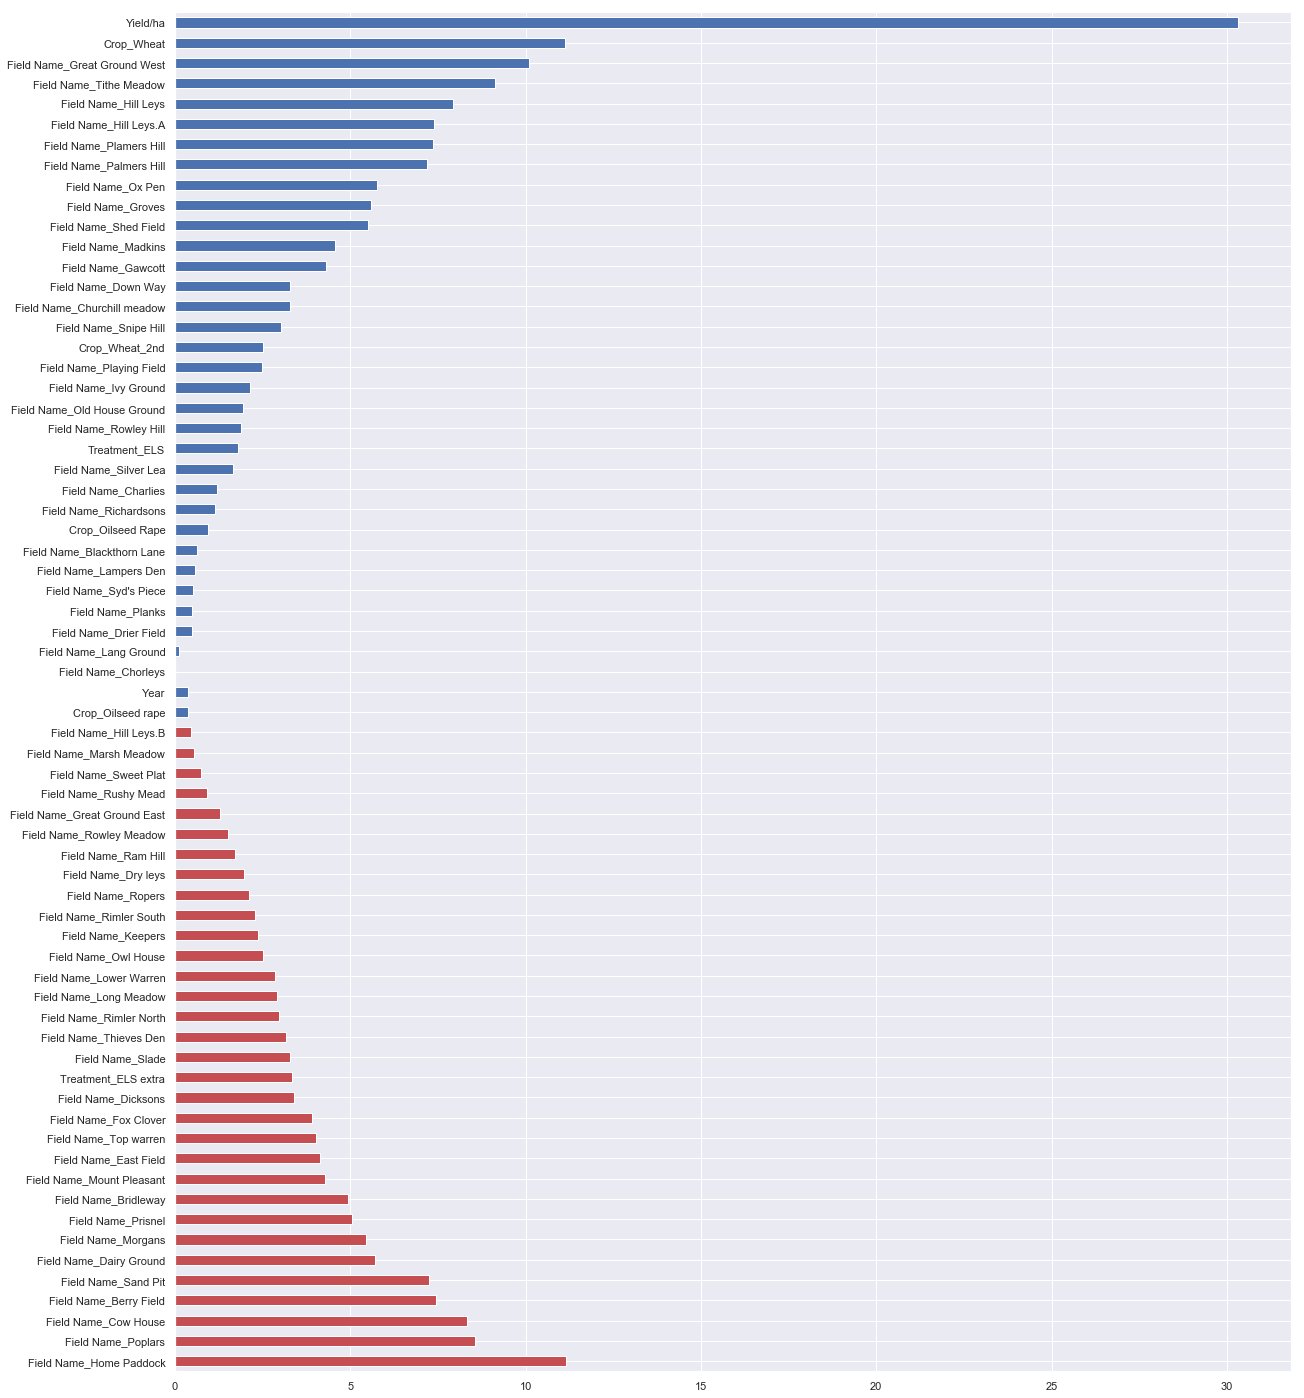

In [72]:
df_coef3.sort_values(by='coefficients').coef_abs.plot(kind='barh',color=colors);

#### A neural network to see if the scores can be improved any further. It appears to improve the test scores massively.

In [57]:
from sklearn import metrics
from sklearn.neural_network import MLPRegressor

In [58]:
nnet = MLPRegressor(hidden_layer_sizes=(10,10,10),solver='lbfgs',activation='relu',random_state=1)
nnet.fit(X_train,y_train)
metrics.mean_squared_error(y_test,nnet.predict(X_test))

552.9764409474935

In [59]:
nnet.score(X_test,y_test)

0.8817168529575636